# Data Reading

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn  
import numpy as np
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
import glob

# location of storing data collected
url = r"./data/videos"
# read a set of data according to the given format of filename
samples_fileName = glob.glob(url+"/Record_2024-*")

## split necessary data from raw data
### input
1. heat plate area 1
rows 250:251, columns 100:101

### output
observer temperature matrix with ridge
rows 250:375, columns 200:250

In [2]:
samples_names = [i[-9:-4] for i in samples_fileName]
samples_files = [pd.read_csv(samples_fileName[i], sep=",", header=None) 
                 for i in range(len(samples_fileName))]

print(samples_files[0].shape)

(640, 481)


In [3]:
#samples_targets = [samples_files[i].iloc[250:375][samples_files[i].columns[200:250]].to_numpy()
#                  for i in range(len(samples_files))]
#len(samples_targets)

In [4]:
# x axis range and y axis range of the input data
input_range = [250,260,100,110]
# x axis range and y axis range of the output data
output_range = [150,200,275,325]

HP_input = [samples_files[i].iloc[input_range[2]:input_range[3]][samples_files[i].columns[input_range[0]:input_range[1]]].to_numpy() 
                   for i in range(len(samples_files))]

samples_targets = [samples_files[i].iloc[output_range[2]:output_range[3]][samples_files[i].columns[output_range[0]:output_range[1]]].to_numpy()
                   for i in range(len(samples_files))]
shape2DField = samples_targets[0].shape



# condense 2D input and output into 1D
HP_input = [i.ravel()  for i in HP_input]
samples_targets = [i.ravel()  for i in samples_targets]


print(f"The defined size of the input-temperature is:{HP_input[0].shape} with a length of {len(HP_input[0])} (number of neurons in the input-layer)")
print(f"The defined size of the output-temperature is (y,x):{shape2DField} with a length of {len(samples_targets[0])} (number of neurons in the output-layer)")


The defined size of the input-temperature is:(100,) with a length of 100 (number of neurons in the input-layer)
The defined size of the output-temperature is (y,x):(50, 50) with a length of 2500 (number of neurons in the output-layer)


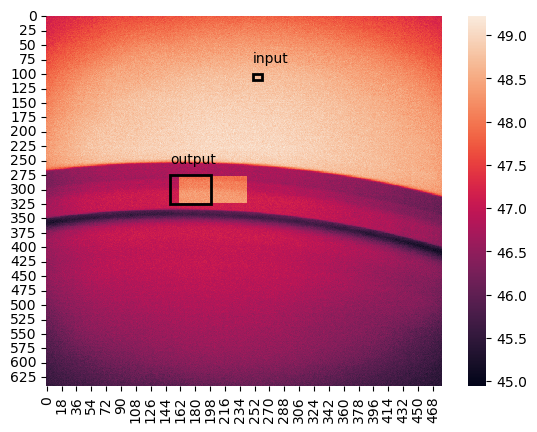

In [5]:
import matplotlib.patches as mpatches

rect_input = mpatches.Rectangle((input_range[0],input_range[2]),
                                input_range[1]-input_range[0]+1,input_range[3]-input_range[2]+1,
                          fill=False, color='black', linewidth=2)
rect_output = mpatches.Rectangle((output_range[0],output_range[2]), 
                                 output_range[1]-output_range[0],output_range[3]-output_range[2],
                          fill=False, color='black', linewidth=2)
sns.heatmap(samples_files[0])

plt.text(input_range[0],input_range[2]-20, 'input')
plt.text(output_range[0],output_range[2]-20, 'output')
plt.gca().add_patch(rect_input)
plt.gca().add_patch(rect_output)


In [6]:
len(HP_input[0]), len(HP_input)

(100, 20)

## split input and target dataset into train and test set

with preset splitting ratio

In [7]:
# the overal dataset will be splitted into 2 sub dataset with randomly selected index
# random state ensure the selected index for train and test
x_train, x_test, y_train, y_test = train_test_split(HP_input,samples_targets, test_size=0.2, random_state=42)
# test_size: the ratio of test data randomly selected from the raw dataset
# x_train, x_test, y_train, y_test 's datatype: dataFrame or Series

In [8]:
print("===============the number of samples: raw input, train, test, train+test===============\n",
      len(HP_input), len(x_train), len(x_test), len(x_train)+ len(x_test), "\n",
      len(samples_targets), len(y_train), len(y_test), len(y_train)+len(y_test))

===============the number of samples: raw input, train, test, train+test===============
 20 16 4 20 
 20 16 4 20


## create a neural network model

In [9]:
#  Deep Neural Network
class DNN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.SELU()
        self.layers = layers
        self.loss_function = nn.L1Loss()#(reduction="mean")
#         self.optimizor = torch.optim.LBFGS(self.parameters())
#         self.schedulor = torch.optim.lr_scheduler.StepLR(self.optimizor, step_size=30, gamma=.1)
        'Initialize neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
    
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            nn.init.xavier_uniform_(self.linears[i].weight.data,  gain=nn.init.calculate_gain('relu'))#, mode='fan_in', nonlinearity='relu')
            # set biases to zero
            nn.init.ones_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,x):
              
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(self.layers)-2):
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a
    
    def loss(self, pred_y: torch.tensor, y: torch.tensor):
        a = self.loss_function(pred_y.float(), y.float())
        return a

### Training and testing model with given data size and layer structure

In [18]:
neurons_hidden_layer = 10000
hidden_layers = 8

# input and output layer size are set automatically by the size of input and output data size
layers = np.array([len(HP_input[0])]+
                  [len(HP_input[0])*2, len(HP_input[0])*3,len(HP_input[0])*4,len(HP_input[0])*5,len(samples_targets[0])*5,len(samples_targets[0])*4,len(samples_targets[0])*3,len(samples_targets[0])*2]+
                  # [int(neurons_hidden_layer)]*hidden_layers+
                  [len(samples_targets[0])])
# creat a new DNN class
net = DNN(layers)

import time
optimizor = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
schedulor = torch.optim.lr_scheduler.ExponentialLR(optimizor, gamma=0.9)#total_iters=4, power=1.0)
train_loss = list()
test_loss = list()
start_time = time.time()
# repetitive time of the training process with be done with all 13 training data
epochs = 40
# overall 20 samples
for epoch in range(epochs):
        # print("======================= training")
        optimizor.zero_grad()
        input_ = np.array(x_train)  # 13 for training
        output_ = np.array(y_train)
        
        pred_output=net(input_)
        loss =  net.loss(pred_output, torch.tensor(output_))  
        loss.backward()

        train_loss.append(loss.detach().numpy())
        
        optimizor.step()
        schedulor.step()
        
        # print("======================= testing")
        test_output = net(np.array(x_test))   # 7 for testing
        loss_test = net.loss(test_output, torch.tensor(np.array(y_test)))
        test_loss.append(loss_test.detach().numpy())
        print(f"train and test loss in {epoch} epochs: {loss}   , {loss_test}")

elapsed = time.time() - start_time


train and test loss in 0 epochs: 65.77542877197266   , 39.100894927978516
train and test loss in 1 epochs: 45.421539306640625   , 28.320337295532227
train and test loss in 2 epochs: 33.291751861572266   , 94.84583282470703
train and test loss in 3 epochs: 108.24712371826172   , 47.33833312988281
train and test loss in 4 epochs: 55.53276062011719   , 39.37617874145508
train and test loss in 5 epochs: 45.92893600463867   , 53.7214241027832
train and test loss in 6 epochs: 61.66218185424805   , 48.222469329833984
train and test loss in 7 epochs: 56.60615539550781   , 45.766937255859375
train and test loss in 8 epochs: 53.90296936035156   , 35.204383850097656
train and test loss in 9 epochs: 41.221954345703125   , 41.35212326049805
train and test loss in 10 epochs: 46.7936897277832   , 29.355213165283203
train and test loss in 11 epochs: 35.52590560913086   , 21.148637771606445
train and test loss in 12 epochs: 25.05389976501465   , 31.176305770874023
train and test loss in 13 epochs: 33.9

In [11]:
print("=========== time cost of this training in sec.\n", np.round(elapsed,2))
len(test_output)

=========== time cost of this training in sec.
 21.49


4

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


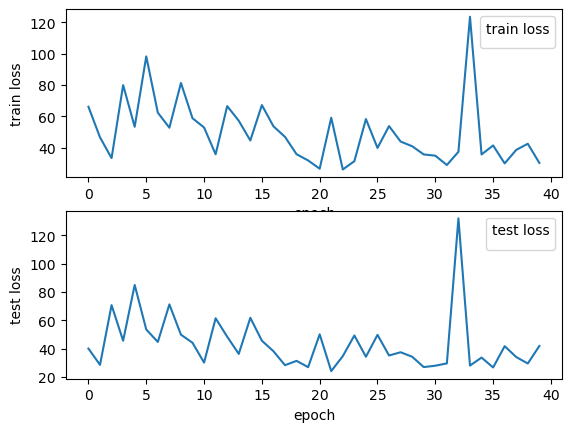

In [12]:
a = pd.DataFrame([list(np.array(train_loss)), list(np.array(test_loss))]).T
a.columns=['train loss', 'test loss']
a['epoch'] = a.index
fig, axs = plt.subplots(nrows=2)
sns.lineplot(x='epoch', y='train loss', data=a, ax=axs[0])
axs[0].legend(title='train loss')
sns.lineplot(x='epoch', y='test loss', data=a, ax=axs[1])
axs[1].legend(title='test loss')

### check the predicted temperature

Result for the heat plate temperature 48.68°C
Average temperature in this temperaturefield is: 13.86°C; (Max: 72.79°C, Min: -44.28°C)


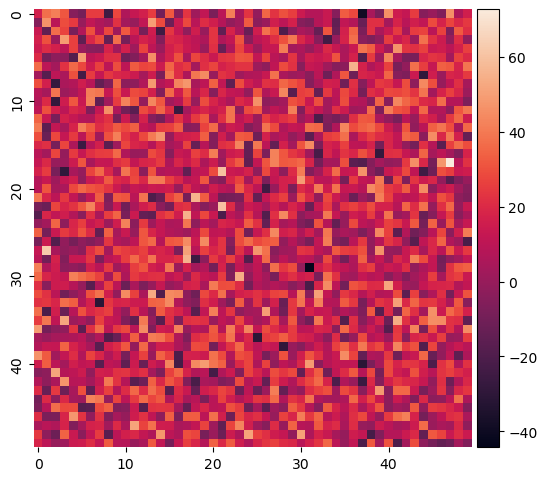

Result for the heat plate temperature 82.21°C
Average temperature in this temperaturefield is: 13.86°C; (Max: 72.79°C, Min: -44.28°C)


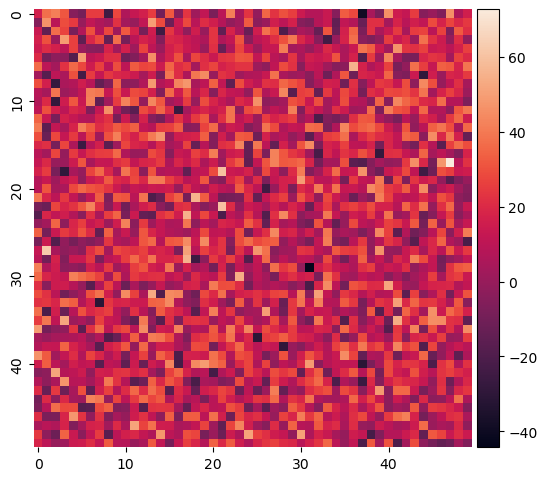

Result for the heat plate temperature 32.1°C
Average temperature in this temperaturefield is: 13.86°C; (Max: 72.79°C, Min: -44.28°C)


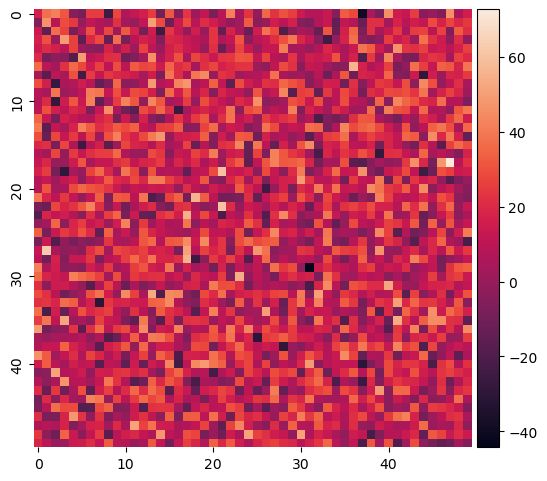

Result for the heat plate temperature 65.62°C
Average temperature in this temperaturefield is: 13.86°C; (Max: 72.79°C, Min: -44.28°C)


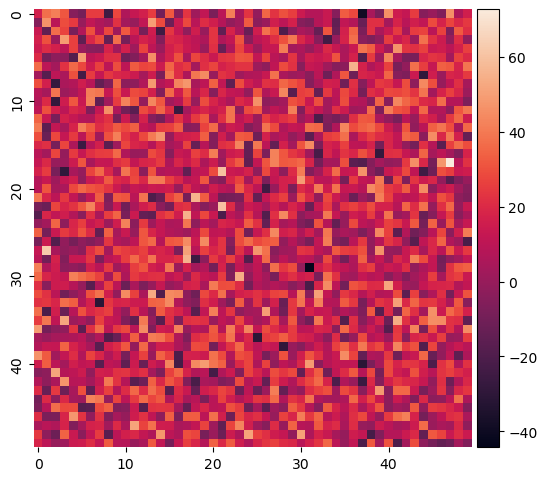

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
new_shape = (output_range[3]-output_range[2],output_range[1]-output_range[0])

for i in range(len(test_output)):
    reshaped_data = np.reshape(test_output[i].detach().numpy(), new_shape)
    tempfield = reshaped_data
    
    print(f"Result for the heat plate temperature {np.round(x_test[i][0],2)}°C")
    print(f"Average temperature in this temperaturefield is: {tempfield.mean():.2f}°C; (Max: {tempfield.max():.2f}°C, Min: {tempfield.min():.2f}°C)")
   
    fig, ax = plt.subplots(figsize=(6,6)) 
    heat_map = sns.heatmap(reshaped_data, ax=ax, square=True,cbar=False)
    
    # Interval for x and y ticks
    x_interval = 5
    y_interval = 5

    # Get current x and y ticks, limit the number of ticks by choosing every nth tick
    xticks = heat_map.get_xticks()
    yticks = heat_map.get_yticks()

    heat_map.set_xticks(xticks[::x_interval])
    heat_map.set_yticks(yticks[::y_interval])
    
    # Create a divider for the existing axes instance and append a new axes for colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    # Generate colorbar
    plt.colorbar(ax.get_children()[0], cax=cax, orientation="vertical")
    plt.show()
    

## check real temperature 

Result for the heat plate temperature 48.68°C
Average temperature in this temperaturefield is: 47.87°C; (Max: 48.56°C, Min: 46.54°C)


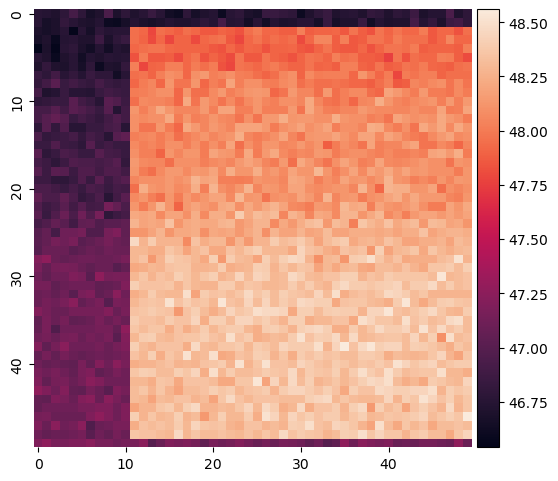

Result for the heat plate temperature 82.21°C
Average temperature in this temperaturefield is: 77.32°C; (Max: 77.85°C, Min: 76.62°C)


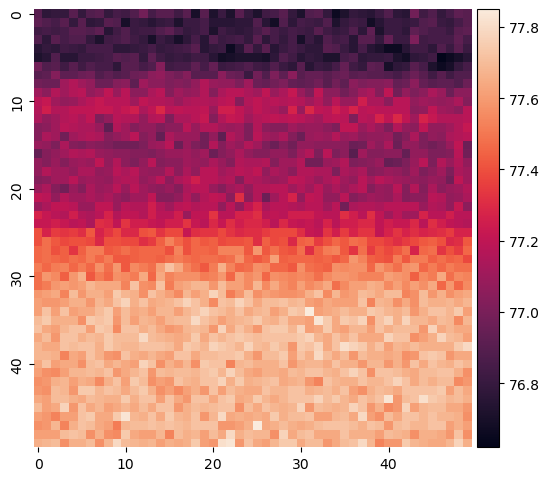

Result for the heat plate temperature 32.1°C
Average temperature in this temperaturefield is: 32.19°C; (Max: 32.74°C, Min: 31.54°C)


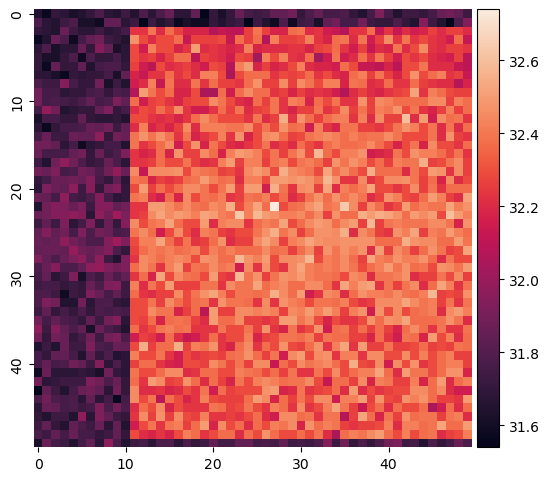

Result for the heat plate temperature 65.62°C
Average temperature in this temperaturefield is: 63.70°C; (Max: 64.65°C, Min: 61.76°C)


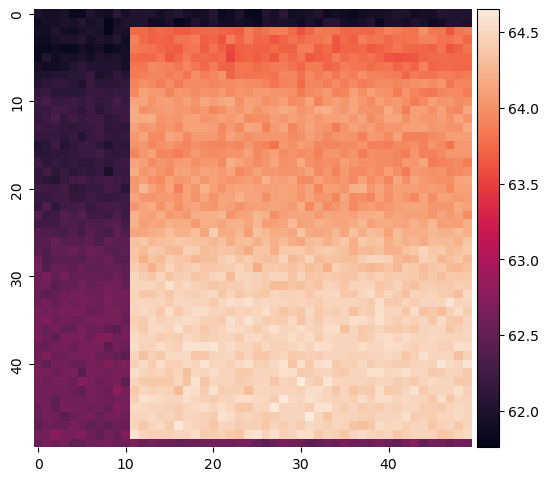

In [14]:
for i in range(len(y_test)):
    #sns.heatmap(np.reshape(y_train[i],new_shape)) 
    #plt.show()

    reshaped_data = np.reshape(y_test[i],new_shape)
    tempfield = reshaped_data

    print(f"Result for the heat plate temperature {np.round(x_test[i][0],2)}°C")
    print(f"Average temperature in this temperaturefield is: {tempfield.mean():.2f}°C; (Max: {tempfield.max():.2f}°C, Min: {tempfield.min():.2f}°C)")
    
    fig, ax = plt.subplots(figsize=(6,6)) 
    heat_map = sns.heatmap(reshaped_data, ax=ax, square=True,cbar=False)
    
    # Interval for x and y ticks
    x_interval = 5
    y_interval = 5

    # Get current x and y ticks, limit the number of ticks by choosing every nth tick
    xticks = heat_map.get_xticks()
    yticks = heat_map.get_yticks()

    heat_map.set_xticks(xticks[::x_interval])
    heat_map.set_yticks(yticks[::y_interval])
    
    # Create a divider for the existing axes instance and append a new axes for colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    # Generate colorbar
    plt.colorbar(ax.get_children()[0], cax=cax, orientation="vertical")
    plt.show()

### error of predicted and real temperature

Result for the heat plate temperature 48.68°C
Average temperature in this temperaturefield is: 31.33°C; (Max: 32.02°C, Min: 30.00°C)


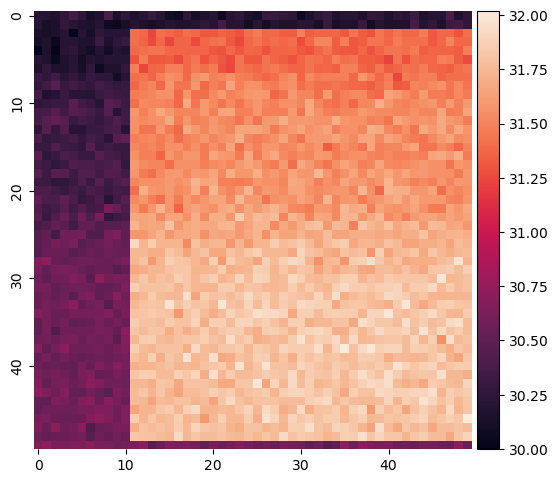

Result for the heat plate temperature 82.21°C
Average temperature in this temperaturefield is: 39.80°C; (Max: 40.33°C, Min: 39.10°C)


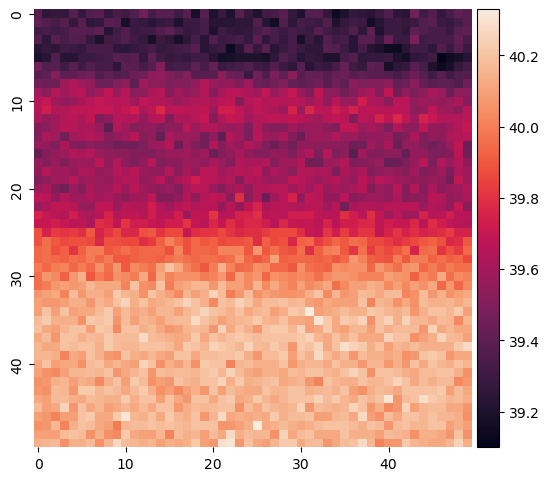

Result for the heat plate temperature 32.1°C
Average temperature in this temperaturefield is: 9.50°C; (Max: 10.15°C, Min: 8.95°C)


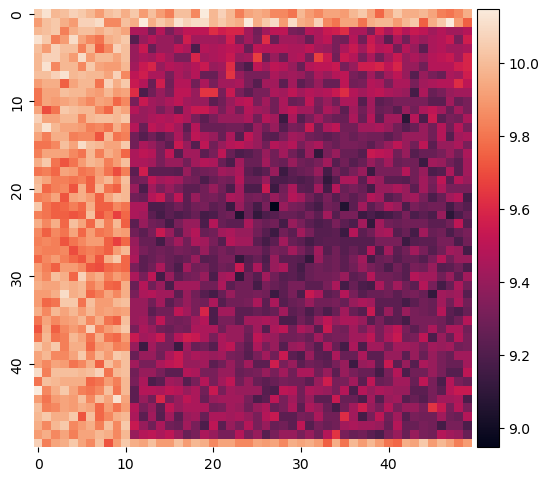

Result for the heat plate temperature 65.62°C
Average temperature in this temperaturefield is: 32.42°C; (Max: 33.37°C, Min: 30.48°C)


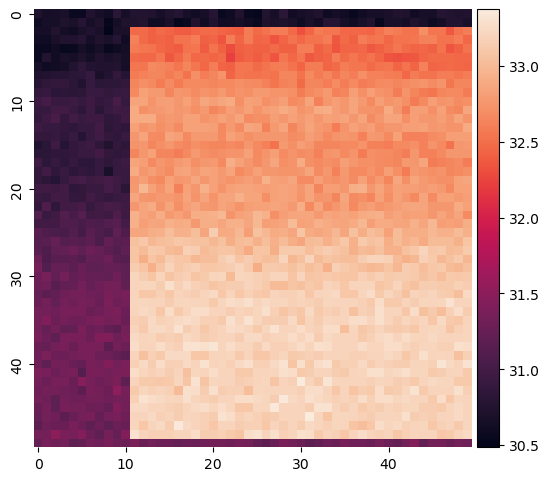

In [15]:
for i in range(len(x_test)):
    #sns.heatmap(np.reshape(np.abs(test_output[i].detach().numpy()-y_test[i]), new_shape))
    #plt.show()

    kiModelPrediction = net(x_test[i])
    reshaped_data = np.reshape(np.abs(kiModelPrediction[i].detach().numpy()-y_test[i]),new_shape)
    tempfield = reshaped_data
    
    print(f"Result for the heat plate temperature {np.round(x_test[i][0],2)}°C")
    print(f"Average temperature in this temperaturefield is: {tempfield.mean():.2f}°C; (Max: {tempfield.max():.2f}°C, Min: {tempfield.min():.2f}°C)")
    
    fig, ax = plt.subplots(figsize=(6,6)) 
    heat_map = sns.heatmap(reshaped_data, ax=ax, square=True,cbar=False)
    
    # Interval for x and y ticks
    x_interval = 5
    y_interval = 5

    # Get current x and y ticks, limit the number of ticks by choosing every nth tick
    xticks = heat_map.get_xticks()
    yticks = heat_map.get_yticks()

    heat_map.set_xticks(xticks[::x_interval])
    heat_map.set_yticks(yticks[::y_interval])
    
    # Create a divider for the existing axes instance and append a new axes for colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    # Generate colorbar
    plt.colorbar(ax.get_children()[0], cax=cax, orientation="vertical")
    plt.show()